# importing

In [67]:
import pandas as pd
import read_geolife
import numpy as np
import utm
import swifter
import math
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,precision_score
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib
import geopandas as gpd

import warnings 
warnings.filterwarnings("ignore")

In [3]:
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)
matplotlib.rcParams.update({'font.size': 20})

# functions

In [34]:
# vectorial function to get distqnces from lat and long
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

# vectorial function to get angle in cartesian space
def getAngle(a, b, c):
    if np.isnan(a).any()|np.isnan(b).any()|np.isnan(c).any():
        return np.nan
    else :
        ang = math.degrees(math.atan2(c[1]-b[1], c[0]-b[0]) - math.atan2(a[1]-b[1], a[0]-b[0]))
        return ang + 360 if ang < 0 else ang
 
def finder(a, b):
    dup = np.searchsorted(a, b)
    uni = np.unique(dup)
    uni = uni[uni < a.shape[0]]
    ret_b = np.zeros(uni.shape[0])
    for idx, val in enumerate(uni):
        bw = np.argmin(np.abs(a[val]-b[dup == val]))
        tt = dup == val
        ret_b[idx] = np.where(tt == True)[0][bw]
    return np.column_stack((uni, ret_b))


def estrattore(a,cilindro_magico):  
    a2=np.array(a.cumsum())
    b=np.cumsum(np.random.choice(cilindro_magico,len(a2)))
    b=b[b<=max(a2)]
    indici=finder(a2, b)[:,0]
    return list(a.iloc[indici].index.values)



# single function to evaluate classifier from multiple point of view
def classificator_analisys(df):
    #preprocessing for classifier
    features=list(df.columns)
    features.remove("label")
    features.remove("user")
    if "time" in features:
        features.remove("time")
    if "tripID" in features:
            features.remove("tripID")

    #clas_df = clas_df.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
    x = df[features]
    y = df['label']

    le = LabelEncoder()
    le = le.fit(y)
    y = le.transform(y)
    if sum(x.columns.isin(["next_label"]))>0 :
        le2 = LabelEncoder()
        le2 = le2.fit(x.next_label)
        x.next_label = le2.transform(x.next_label)
        x.prev_label = le2.transform(x.prev_label)        
    
    #classification (70-30 train test split)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle=True)
    clf = XGBClassifier(eval_metric='mlogloss').fit(x_train,y_train)
    y_test_predict = clf.predict(x_test)

    labels_ordered=["bus","taxi","car","subway","train","walk","bike"]
    precisions=precision_score(y_test, y_test_predict, average=None, labels=le.transform(labels_ordered))
    plt.bar(labels_ordered,precisions)
    plt.title("XGBoost precision",size=20)
    plt.xticks(rotation='vertical')
    plt.show()
    print("avg precision= %.3f"% (np.mean(precisions)))
    plt.figure(figsize=(17,4))
    plt.title("XGBoost f.i.")
    plt.bar(features,clf.feature_importances_)
    plt.xticks(rotation='vertical')
    plt.show()
    plt.figure(figsize=(12, 12))
    plt.title("XGBoost",size=20)
    plot_confusion_matrix(clf, x_test, y_test, 
                          display_labels=labels_ordered,
                          labels=le.transform(labels_ordered),
                          cmap=plt.cm.YlOrRd,
                          normalize='true',  
                          ax=plt.gca())
    plt.show()
    #10 fold cross validation
    clf_acc = cross_val_score(clf, x, y, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42))
    print("Accuracy from Crossvalidation mean=%.3f std=%.3f"% (clf_acc.mean(),clf_acc.std()))
    clf_prec = cross_val_score(clf, x, y, scoring="precision_macro", cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42))
    print("precision from Crossvalidation mean=%.3f std=%.3f"% (clf_prec.mean(),clf_prec.std()))

# dataset

In [68]:
# here i'm importing the entire collection of geolife trajectories, i built this dataframe simply concatenating multiple files. The original geolife data is stored in multiple folders, one for each user, containing the gps logs in ".pkl" files and the declared transpor mode in a ".txt" file. Using timestamps is possible to merge the two informations: location and transport mode. 
df = read_geolife.read_all_users("Geolife Trajectories 1.3/Data")

[1/183] processing user 135
[2/183] processing user 132
[3/183] processing user 104
[4/183] processing user 103
[5/183] processing user 168
[6/183] processing user 157
[7/183] processing user 150
[8/183] processing user 159
[9/183] processing user 166
[10/183] processing user 161
[11/183] processing user 102
[12/183] processing user 105
[13/183] processing user 133
[14/183] processing user 134
[15/183] processing user 160
[16/183] processing user 158
[17/183] processing user 167
[18/183] processing user 151
[19/183] processing user 169
[20/183] processing user 156
[21/183] processing user 024
[22/183] processing user 023
[23/183] processing user 015
[24/183] processing user .DS_Store


ValueError: No objects to concatenate

In [ ]:
#LABELs: enumeration criteria
mode_names = ['walk', 'bike', 'bus', 'car', 'subway','train', 'airplane', 'boat', 'run', 'motorcycle', 'taxi']
mode_ids = {s : i + 1 for i, s in enumerate(mode_names)}
df["transport"]=0

df["transport"][df["label"]==1]="walk"
df["transport"][df["label"]==2]="bike"
df["transport"][df["label"]==3]="bus"
df["transport"][df["label"]==4]="car"
df["transport"][df["label"]==5]="subway"
df["transport"][df["label"]==6]="train"
df["transport"][df["label"]==7]="airplane"
df["transport"][df["label"]==8]="boat"
df["transport"][df["label"]==9]="run"
df["transport"][df["label"]==10]="motorcycle"
df["transport"][df["label"]==11]="taxi"

df["label"]=df["transport"]
df.drop(columns="transport",inplace=True)

#filtering only for labelled data
labelled_df=df[df["label"]!=0]

#remove duplicates (this will keep finite the calculation of speed and other features)
labelled_df=labelled_df[-labelled_df.duplicated(subset=["user","time"])]

#tripID (trips are identified leveraging on the ground truth, a new trip is defined when, scrolling the dataframe, the mode changes, the user changes or the time distance between two samples is higher than one our)
labelled_df=labelled_df.sort_values(by=["user","time"])
labelled_df['timedelta'] = (labelled_df.time.shift(-1) - labelled_df.time).apply(lambda x: x.total_seconds())
support_df=pd.DataFrame()
support_df["modechange"]=(labelled_df["label"] != labelled_df["label"].shift(1))*1
support_df["userchange"]=(labelled_df["user"] != labelled_df["user"].shift(1))*1
support_df["timegap"]   =((labelled_df['timedelta'].shift(1)>60*60)|(labelled_df['timedelta'].shift(1)<0))*1
labelled_df["tripID"]=np.cumsum(support_df["modechange"] | support_df["userchange"] | support_df["timegap"])
aux_df=labelled_df.groupby('tripID').agg(
    
    label=("label", "first"),
    nr_pti=("label", len),
    lon_start=("lon", "first"),
    lat_start=("lat", "first"),
    lon_end=("lon", "first"),
    lat_end=("lat", "first"),
    
).reset_index()

#bbox (analysis is focused mainly on the city of Beijing, over 80% of labelled points fall inside this region. Trips outside the Beijing bbox are included if they are labelled as "train" or "subway", otherwise there would be an underrepresentation of these two classes)
min_lon,max_lon,min_lat,max_lat = 116.081035,116.751230,39.695257,40.212878
bboxed_aux_df = aux_df[((aux_df["lon_start"]>min_lon) & (aux_df["lon_start"]<max_lon) & (aux_df["lon_end"]>min_lon) & (aux_df["lon_end"]<max_lon) & (aux_df["lat_start"]>min_lat) & (aux_df["lat_start"]<max_lat) & (aux_df["lat_end"]>min_lat) & (aux_df["lat_end"]<max_lat)) | (aux_df["label"]=="train") | (aux_df["label"]=="subway")]
bboxed_labelled_df=labelled_df[labelled_df["tripID"].isin(bboxed_aux_df["tripID"])]

#error removal (there is an outlier coordinate, that fall outside the possible values that latitude can assume)
bboxed_labelled_df=bboxed_labelled_df[bboxed_labelled_df.lat<90]
bboxed_labelled_df.reset_index(drop=True,inplace=True)

#modes removal (classes too poorly populated)
curr_df=bboxed_labelled_df
curr_df=curr_df[-curr_df["label"].isin(["boat","run","airplane"])]

## point-level feature

In [7]:
#spacedelta (distance between two subsequent points)
curr_df["spacedelta"]=haversine_np(curr_df.lon, curr_df.lat, curr_df.lon.shift(-1), curr_df.lat.shift(-1))*1000 #m
#speed (avg speed between two points)
curr_df['speed']=curr_df['spacedelta']/curr_df['timedelta']*3.6
#angle (geographical coordinates are converted in the UTM reference system, a flat representation of coordinates. An angle can be defined every three points)
x,y=utm.from_latlon(np.array(curr_df.lat),np.array(curr_df.lon))[0:2]
curr_df["utm"]=list(zip(x,y))
curr_df["previous_utm"]=curr_df.shift(+1).utm
curr_df["next_utm"]=curr_df.shift(-1).utm
curr_df["angle"] = curr_df.swifter.apply(lambda x: getAngle(x.previous_utm, x.utm, x.next_utm), axis=1)
curr_df.drop(columns=["utm","previous_utm","next_utm"],inplace=True)
#acceleration (isn't properly the measure of instantaneous acceleration, it needs three points to be evaluated, can be subject to distortion if timedeltas are eterogeneous, but indicates in a rough way the variation of speed from a segment to the next one)
curr_df["acceleration"]=(curr_df["speed"].shift(-1)-curr_df["speed"])/3.6/curr_df["timedelta"]
#invalidate meaningless features (starting and ending points of trips)
curr_df["timedelta"][curr_df.tripID!=curr_df.tripID.shift(-1)]=np.nan
curr_df["spacedelta"][curr_df.tripID!=curr_df.tripID.shift(-1)]=np.nan
curr_df["speed"][curr_df.tripID!=curr_df.tripID.shift(-1)]=np.nan
curr_df["angle"][(curr_df.tripID!=curr_df.tripID.shift(-1))|(curr_df.tripID!=curr_df.tripID.shift(1))]=np.nan
curr_df["acceleration"][(curr_df.tripID!=curr_df.tripID.shift(-1))|(curr_df.tripID!=curr_df.tripID.shift(-2))]=np.nan

Pandas Apply:   0%|          | 0/4316725 [00:00<?, ?it/s]

## trip-level features

In [8]:
clas_df=curr_df.groupby('tripID').agg(
    
    user=("user", "first"),
    label=("label", "first"),
    
    lon_start=("lon", "first"),
    lat_start=("lat", "first"),
    lon_end=("lon", "last"),
    lat_end=("lat", "last"),
    
    nr_pti=("user", len),
    
    distance=('spacedelta', sum), #beeline distance, point to point
    quant5d=("spacedelta", lambda x: x.quantile(0.05)),
    quant25d=("spacedelta", lambda x: x.quantile(0.25)),
    quant50d=("spacedelta", lambda x: x.quantile(0.5)),
    quant75d=("spacedelta", lambda x: x.quantile(0.75)),
    quant95d=("spacedelta", lambda x: x.quantile(0.95)),
    
    duration=('timedelta', sum),
    
    speed=("speed", "mean"),
    quant5s=("speed", lambda x: x.quantile(0.05)),
    quant25s=("speed", lambda x: x.quantile(0.25)),
    quant50s=("speed", lambda x: x.quantile(0.5)),
    quant75s=("speed", lambda x: x.quantile(0.75)),
    quant95s=("speed", lambda x: x.quantile(0.95)),
    
    #acceleration
    acceleration_avg=("acceleration", "mean"),
    skewac=("acceleration", "skew"),
    kurtac=("acceleration", lambda x: x.kurt()),
    quant5ac=("acceleration", lambda x: x.quantile(0.05)),
    quant25ac=("acceleration", lambda x: x.quantile(0.25)),
    quant50ac=("acceleration", lambda x: x.quantile(0.5)),
    quant75ac=("acceleration", lambda x: x.quantile(0.75)),
    quant95ac=("acceleration", lambda x: x.quantile(0.95)),
    
    angle_avg=("angle", "mean"),
    skewan=("angle", "skew"),
    kurtan=("angle", lambda x: x.kurt()),
    quant5an=("angle", lambda x: x.quantile(0.05)),
    quant25an=("angle", lambda x: x.quantile(0.25)),
    quant50an=("angle", lambda x: x.quantile(0.5)),
    quant75an=("angle", lambda x: x.quantile(0.75)),
    quant95an=("angle", lambda x: x.quantile(0.95))
    
)

clas_df["straightness"]=haversine_np(clas_df["lon_start"], clas_df["lat_start"], clas_df["lon_end"], clas_df["lat_end"])/clas_df["distance"]
clas_df.drop(columns=['lon_start','lon_end','lat_start','lat_end'], inplace=True)

In [9]:
#removing point trips
clas_df=clas_df[(clas_df.duration!=0)&(clas_df.distance!=0)]

# classifier evaluation

### Using only motion related features

#### all trips

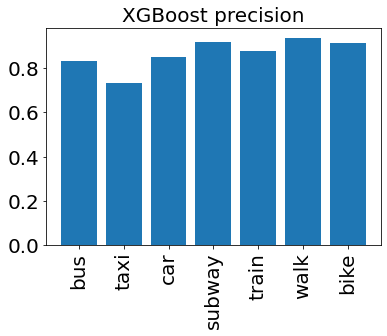

avg precision= 0.865


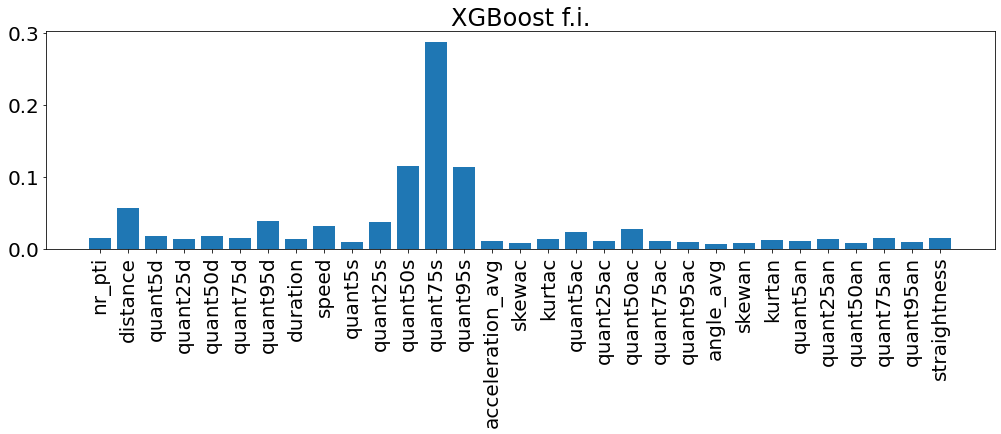

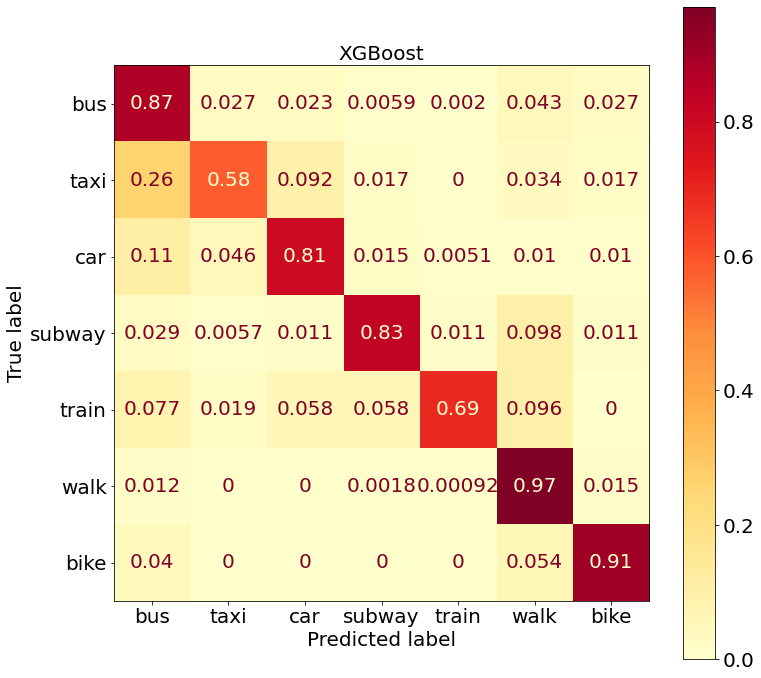

Accuracy from Crossvalidation mean=0.891 std=0.010
precision from Crossvalidation mean=0.858 std=0.018


In [ ]:
classificator_analisys(clas_df)

#### trips containing more than 20 points

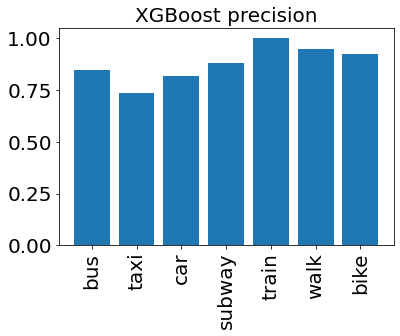

avg precision= 0.879


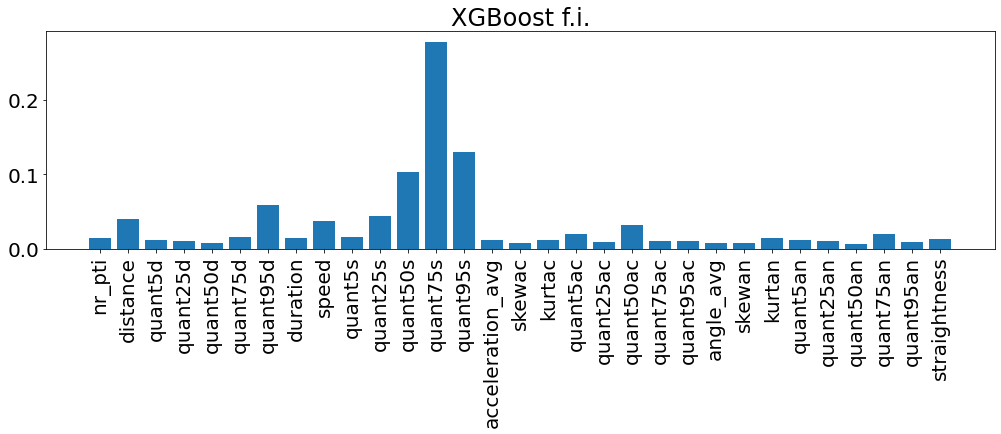

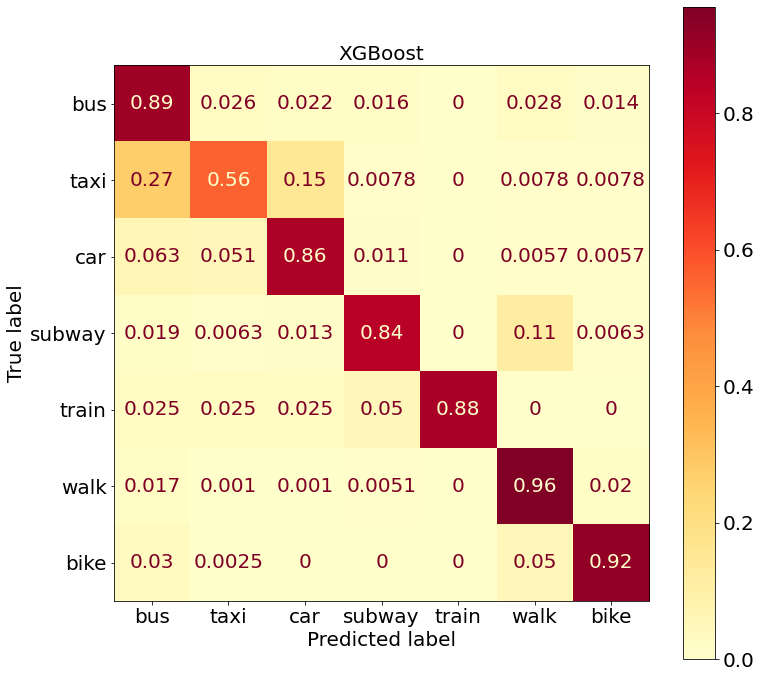

Accuracy from Crossvalidation mean=0.902 std=0.007
precision from Crossvalidation mean=0.882 std=0.012


In [40]:
classificator_analisys(clas_df[clas_df.nr_pti>20])

#### trips containing less than 20 points

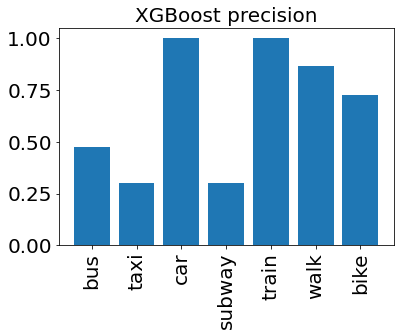

avg precision= 0.667


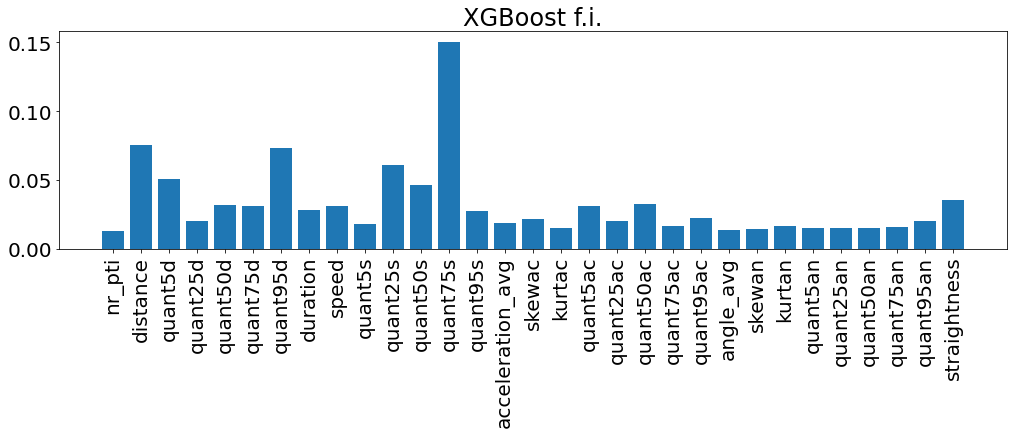

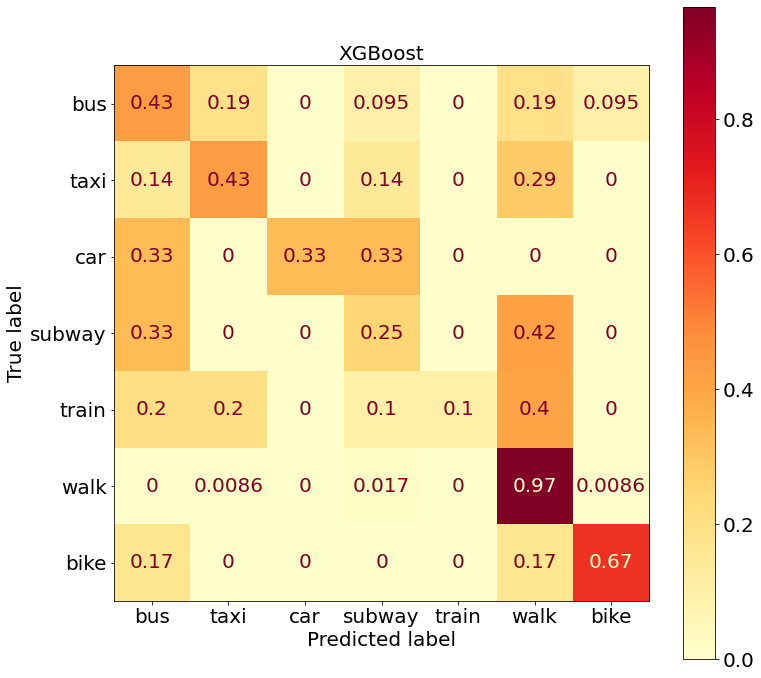

Accuracy from Crossvalidation mean=0.773 std=0.032
precision from Crossvalidation mean=0.591 std=0.070


In [41]:
classificator_analisys(clas_df[clas_df.nr_pti<=20])

### Using motion + POI features

#### POI point-level features

In [10]:
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'

# READ KML file to a geopandas dataframe 

geo_train_stations = gpd.read_file('train_stations2.kml',driver='KML')
geo_subway_stations = gpd.read_file('subway_stations.kml',driver='KML')
geo_bus_stops = gpd.read_file('bus_stops.kml',driver='KML')
geo_airports = gpd.read_file('airports.kml',driver='KML')
geo_airports['geometry'] = geo_airports.centroid
# Create Pandas Dataframe from GeoPandas 

train_stations= pd.DataFrame(geo_train_stations)
subway_stations= pd.DataFrame(geo_subway_stations)
bus_stops= pd.DataFrame(geo_bus_stops)
airports= pd.DataFrame(geo_airports)

# Extract latitude and longitude from the KML geometry column
train_stations['lat'] = train_stations.geometry.apply(lambda p: p.y)
train_stations['lon'] = train_stations.geometry.apply(lambda p: p.x)
subway_stations['lat'] = subway_stations.geometry.apply(lambda p: p.y)
subway_stations['lon'] = subway_stations.geometry.apply(lambda p: p.x)
bus_stops['lat'] = bus_stops.geometry.apply(lambda p: p.y)
bus_stops['lon'] = bus_stops.geometry.apply(lambda p: p.x)
airports['lat'] = airports.geometry.apply(lambda p: p.y)
airports['lon'] = airports.geometry.apply(lambda p: p.x)


#evaluating for each point: does it belong to a station? which one?

curr_df["train_station"]=False
curr_df["tr_st_id"]=""
for i in train_stations.index:
    belong_to_curr_station= (haversine_np(train_stations.loc[i,"lon"], train_stations.loc[i,"lat"], curr_df["lon"], curr_df["lat"])<0.3)
    curr_df["train_station"]= (curr_df["train_station"]) | (belong_to_curr_station) #distanza tra la stazione e ciascun punto < 0,3km
    curr_df["tr_st_id"].loc[belong_to_curr_station]=i #dove è presente una stazione, gli assegno i come ID
    
curr_df["subway_station"]=False
curr_df["sub_st_id"]=""
for i in subway_stations.index:
    belong_to_curr_station= (haversine_np(subway_stations.loc[i,"lon"], subway_stations.loc[i,"lat"], curr_df["lon"], curr_df["lat"])<0.1)
    curr_df["subway_station"]= (curr_df["subway_station"]) | (belong_to_curr_station) #distanza tra la stazione e ciascun punto < 0,3km
    curr_df["sub_st_id"].loc[belong_to_curr_station]=i #dove è presente una stazione, gli assegno i come ID

curr_df["bus_stop"]=False
curr_df["bus_st_id"]=""
for i in bus_stops.index:
    belong_to_curr_station= (haversine_np(bus_stops.loc[i,"lon"], bus_stops.loc[i,"lat"], curr_df["lon"], curr_df["lat"])<0.1)
    curr_df["bus_stop"]= (curr_df["bus_stop"]) | (belong_to_curr_station) #distanza tra la stazione e ciascun punto < 0,3km
    curr_df["bus_st_id"].loc[belong_to_curr_station]=i #dove è presente una stazione, gli assegno i come ID
    
curr_df["airport"]=False
curr_df["airport_id"]=""
for i in airports.index:
    belong_to_curr_station= (haversine_np(airports.loc[i,"lon"], airports.loc[i,"lat"], curr_df["lon"], curr_df["lat"])<0.5)
    curr_df["airport"]= (curr_df["airport"]) | (belong_to_curr_station) #distanza tra la stazione e ciascun punto < 0,5km
    curr_df["airport_id"].loc[belong_to_curr_station]=i #dove è presente una stazione, gli assegno i come ID



#### POI trip-level features

In [11]:
clas_df=curr_df.groupby('tripID').agg(
    
    user=("user", "first"),
    label=("label", "first"),
    
    lon_start=("lon", "first"),
    lat_start=("lat", "first"),
    lon_end=("lon", "last"),
    lat_end=("lat", "last"),
    
    nr_pti=("user", len),
    nr_pti_tr_st=("train_station", sum), #numero punti in stazioni treno
    nr_tr_st=("tr_st_id", lambda x: len(x.unique())-1), #numero stazioni uniche toccate
    nr_pti_sub_st=("subway_station", sum), #numero punti in stazioni metro
    nr_sub_st=("sub_st_id", lambda x: len(x.unique())-1), #numero stazioni uniche toccate
    nr_pti_bus_st=("bus_stop", sum), #numero punti in bus stop
    nr_bus_st=("bus_st_id", lambda x: len(x.unique())-1), #numero stazioni uniche toccate
    nr_pti_air=("airport", sum), #numero punti in bus stop
    nr_air=("airport_id", lambda x: len(x.unique())-1), #numero stazioni uniche toccate
    
    distance=('spacedelta', sum), #beeline distance, point to point
    quant5d=("spacedelta", lambda x: x.quantile(0.05)),
    quant25d=("spacedelta", lambda x: x.quantile(0.25)),
    quant50d=("spacedelta", lambda x: x.quantile(0.5)),
    quant75d=("spacedelta", lambda x: x.quantile(0.75)),
    quant95d=("spacedelta", lambda x: x.quantile(0.95)),
    
    duration=('timedelta', sum),
    
    speed=("speed", "mean"),
    quant5s=("speed", lambda x: x.quantile(0.05)),
    quant25s=("speed", lambda x: x.quantile(0.25)),
    quant50s=("speed", lambda x: x.quantile(0.5)),
    quant75s=("speed", lambda x: x.quantile(0.75)),
    quant95s=("speed", lambda x: x.quantile(0.95)),
    
    #acceleration
    acceleration_avg=("acceleration", "mean"),
    skewac=("acceleration", "skew"),
    kurtac=("acceleration", lambda x: x.kurt()),
    quant5ac=("acceleration", lambda x: x.quantile(0.05)),
    quant25ac=("acceleration", lambda x: x.quantile(0.25)),
    quant50ac=("acceleration", lambda x: x.quantile(0.5)),
    quant75ac=("acceleration", lambda x: x.quantile(0.75)),
    quant95ac=("acceleration", lambda x: x.quantile(0.95)),
    
    angle_avg=("angle", "mean"),
    skewan=("angle", "skew"),
    kurtan=("angle", lambda x: x.kurt()),
    quant5an=("angle", lambda x: x.quantile(0.05)),
    quant25an=("angle", lambda x: x.quantile(0.25)),
    quant50an=("angle", lambda x: x.quantile(0.5)),
    quant75an=("angle", lambda x: x.quantile(0.75)),
    quant95an=("angle", lambda x: x.quantile(0.95))
    
)

clas_df["straightness"]=haversine_np(clas_df["lon_start"], clas_df["lat_start"], clas_df["lon_end"], clas_df["lat_end"])/clas_df["distance"]
clas_df.drop(columns=['lon_start','lon_end','lat_start','lat_end'], inplace=True)

# POI features
clas_df["tr_touch_div_km"]=(clas_df["nr_tr_st"]>0)/clas_df["distance"] #stazione si/no / km , feature strana ma funziona
clas_df["sub_touch_div_km"]=(clas_df["nr_sub_st"]>0)/clas_df["distance"]
clas_df["bus_touch_div_km"]=(clas_df["nr_bus_st"]>0)/clas_df["distance"]

clas_df["tr_st_x_km"]=clas_df["nr_tr_st"]/clas_df["distance"]
clas_df["sub_st_x_km"]=clas_df["nr_sub_st"]/clas_df["distance"]
clas_df["bus_st_x_km"]=clas_df["nr_bus_st"]/clas_df["distance"]

clas_df["tr_st_x_sec"]=clas_df["nr_tr_st"]/clas_df["duration"]
clas_df["sub_st_x_sec"]=clas_df["nr_sub_st"]/clas_df["duration"]
clas_df["bus_st_x_sec"]=clas_df["nr_bus_st"]/clas_df["duration"]

clas_df["pti_tr_st_x_km"]=clas_df["nr_pti_tr_st"]/clas_df["distance"]
clas_df["pti_sub_st_x_km"]=clas_df["nr_pti_sub_st"]/clas_df["distance"]
clas_df["pti_bus_st_x_km"]=clas_df["nr_pti_bus_st"]/clas_df["distance"]

clas_df["pti_tr_st_x_sec"]=clas_df["nr_pti_tr_st"]/clas_df["duration"]
clas_df["pti_sub_st_x_sec"]=clas_df["nr_pti_sub_st"]/clas_df["duration"]
clas_df["pti_bus_st_x_sec"]=clas_df["nr_pti_bus_st"]/clas_df["duration"]

In [12]:
#removing point trips
clas_df=clas_df[(clas_df.duration!=0)&(clas_df.distance!=0)]

#### all trips

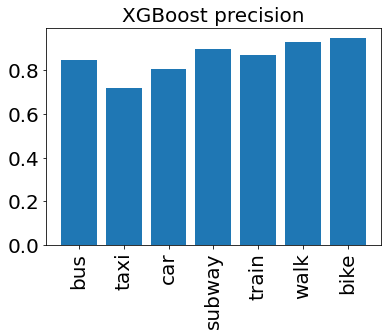

avg precision= 0.858


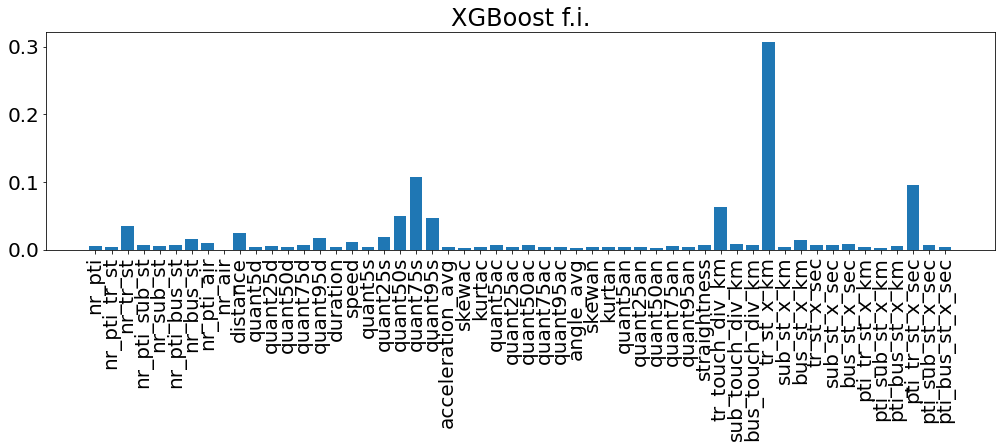

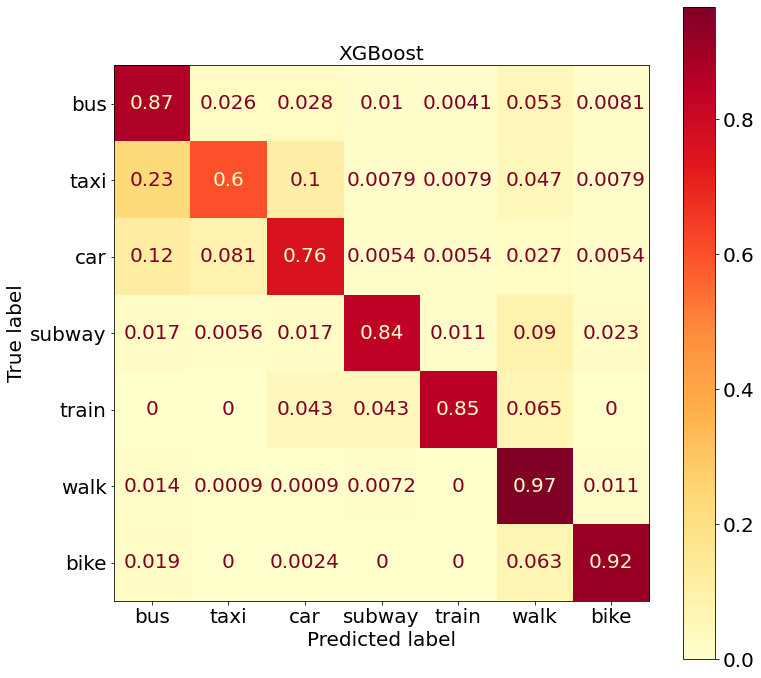

Accuracy from Crossvalidation mean=0.899 std=0.008
precision from Crossvalidation mean=0.871 std=0.015


In [48]:
classificator_analisys(clas_df)

### Using only speed distribution as feature

In [19]:
clas_df=curr_df.groupby('tripID').agg(
    
    user=("user", "first"),
    label=("label", "first"),
    time=("time", "first"),
    
    lon_start=("lon", "first"),
    lat_start=("lat", "first"),
    lon_end=("lon", "last"),
    lat_end=("lat", "last"),
    
    nr_pti=("user", len),
    nr_pti_tr_st=("train_station", sum), #numero punti in stazioni treno
    nr_tr_st=("tr_st_id", lambda x: len(x.unique())-1), #numero stazioni uniche toccate
    nr_pti_sub_st=("subway_station", sum), #numero punti in stazioni metro
    nr_sub_st=("sub_st_id", lambda x: len(x.unique())-1), #numero stazioni uniche toccate
    nr_pti_bus_st=("bus_stop", sum), #numero punti in bus stop
    nr_bus_st=("bus_st_id", lambda x: len(x.unique())-1), #numero stazioni uniche toccate
    nr_pti_air=("airport", sum), #numero punti in bus stop
    nr_air=("airport_id", lambda x: len(x.unique())-1), #numero stazioni uniche toccate
    
    distance=('spacedelta', sum), #beeline distance, point to point
    quant5d=("spacedelta", lambda x: x.quantile(0.05)),
    quant25d=("spacedelta", lambda x: x.quantile(0.25)),
    quant50d=("spacedelta", lambda x: x.quantile(0.5)),
    quant75d=("spacedelta", lambda x: x.quantile(0.75)),
    quant95d=("spacedelta", lambda x: x.quantile(0.95)),
    
    duration=('timedelta', sum),
    
    speed=("speed", "mean"),
    quant5s=("speed", lambda x: x.quantile(0.05)),
    quant25s=("speed", lambda x: x.quantile(0.25)),
    quant50s=("speed", lambda x: x.quantile(0.5)),
    quant75s=("speed", lambda x: x.quantile(0.75)),
    quant95s=("speed", lambda x: x.quantile(0.95)),
    
    #acceleration
    acceleration_avg=("acceleration", "mean"),
    skewac=("acceleration", "skew"),
    kurtac=("acceleration", lambda x: x.kurt()),
    quant5ac=("acceleration", lambda x: x.quantile(0.05)),
    quant25ac=("acceleration", lambda x: x.quantile(0.25)),
    quant50ac=("acceleration", lambda x: x.quantile(0.5)),
    quant75ac=("acceleration", lambda x: x.quantile(0.75)),
    quant95ac=("acceleration", lambda x: x.quantile(0.95)),
    
    angle_avg=("angle", "mean"),
    skewan=("angle", "skew"),
    kurtan=("angle", lambda x: x.kurt()),
    quant5an=("angle", lambda x: x.quantile(0.05)),
    quant25an=("angle", lambda x: x.quantile(0.25)),
    quant50an=("angle", lambda x: x.quantile(0.5)),
    quant75an=("angle", lambda x: x.quantile(0.75)),
    quant95an=("angle", lambda x: x.quantile(0.95))
    
)

clas_df["straightness"]=haversine_np(clas_df["lon_start"], clas_df["lat_start"], clas_df["lon_end"], clas_df["lat_end"])/clas_df["distance"]
clas_df.drop(columns=['lon_start','lon_end','lat_start','lat_end'], inplace=True)

# POI features
clas_df["tr_touch_div_km"]=(clas_df["nr_tr_st"]>0)/clas_df["distance"] #stazione si/no / km , feature strana ma funziona
clas_df["sub_touch_div_km"]=(clas_df["nr_sub_st"]>0)/clas_df["distance"]
clas_df["bus_touch_div_km"]=(clas_df["nr_bus_st"]>0)/clas_df["distance"]

clas_df["tr_st_x_km"]=clas_df["nr_tr_st"]/clas_df["distance"]
clas_df["sub_st_x_km"]=clas_df["nr_sub_st"]/clas_df["distance"]
clas_df["bus_st_x_km"]=clas_df["nr_bus_st"]/clas_df["distance"]

clas_df["tr_st_x_sec"]=clas_df["nr_tr_st"]/clas_df["duration"]
clas_df["sub_st_x_sec"]=clas_df["nr_sub_st"]/clas_df["duration"]
clas_df["bus_st_x_sec"]=clas_df["nr_bus_st"]/clas_df["duration"]

clas_df["pti_tr_st_x_km"]=clas_df["nr_pti_tr_st"]/clas_df["distance"]
clas_df["pti_sub_st_x_km"]=clas_df["nr_pti_sub_st"]/clas_df["distance"]
clas_df["pti_bus_st_x_km"]=clas_df["nr_pti_bus_st"]/clas_df["distance"]

clas_df["pti_tr_st_x_sec"]=clas_df["nr_pti_tr_st"]/clas_df["duration"]
clas_df["pti_sub_st_x_sec"]=clas_df["nr_pti_sub_st"]/clas_df["duration"]
clas_df["pti_bus_st_x_sec"]=clas_df["nr_pti_bus_st"]/clas_df["duration"]

#rimuovo viaggi puntiformi
clas_df=clas_df[(clas_df.duration!=0)&(clas_df.distance!=0)]

In [20]:
# dataframe distribuzione
labels=[]
dist_df=pd.DataFrame()
for i in clas_df.index.unique():
    target_df=curr_df[curr_df["tripID"]==i]
    height=pd.DataFrame(np.histogram(target_df["speed"], bins=40,range=(0,300) ,normed=True)[0])
    height=height.append(pd.Series(i),ignore_index=True)
    dist_df=pd.concat([dist_df , height],  axis=1)
    labels.append(target_df["label"].iloc[0])
dist_df=dist_df.transpose()
dist_df=dist_df.rename({40:'tripID'}, axis=1)
big_df = pd.merge(dist_df, clas_df, on=['tripID'])
big_df["prev_label"]=big_df.label.shift(+1)
big_df["next_label"]=big_df.label.shift(-1)

#invalido i label insensati
#big_df["prev_label"][(big_df.user!=big_df.user.shift(+1))|((big_df.time-big_df.time.shift(+1)).dt.total_seconds()>30*60)]=np.nan
#big_df["next_label"][(big_df.user!=big_df.user.shift(-1))|((big_df.time.shift(-1)-big_df.time).dt.total_seconds()>30*60)]=np.nan

#new column names
nomi=[str(i/40*300+300/40/2)+"km/h" for i in range(40)]
nomi.extend(big_df.columns[40:])
big_df.columns=nomi

aux_df=big_df[np.append(big_df.columns[0:40],["label"])]

In [21]:
aux_df.iloc[:,[0,1,2,3,38,39,40]]

,3.75km/h,11.25km/h,18.75km/h,26.25km/h,288.75km/h,296.25km/h,label
0,0.029530,0.002386,0.002088,0.004176,0.0,0.0,train
1,0.018832,0.003766,0.001255,0.002762,0.0,0.0,train
2,0.009681,0.003080,0.000880,0.001760,0.0,0.0,train
3,0.012795,0.004040,0.002020,0.004040,0.0,0.0,train
4,0.007459,0.001865,0.000932,0.001865,0.0,0.0,train
...,...,...,...,...,...,...,...
8522,0.019858,0.021986,0.022695,0.011348,0.0,0.0,bus
8523,0.110097,0.021024,0.002213,0.000000,0.0,0.0,walk
8524,0.003774,0.005031,0.023899,0.017610,0.0,0.0,bus
8525,0.124675,0.006926,0.001732,0.000000,0.0,0.0,walk


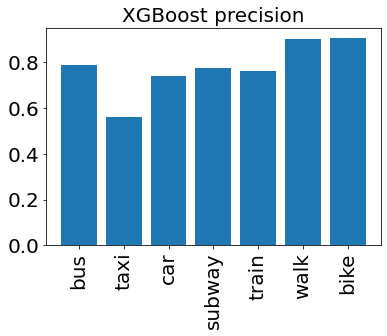

avg precision= 0.777


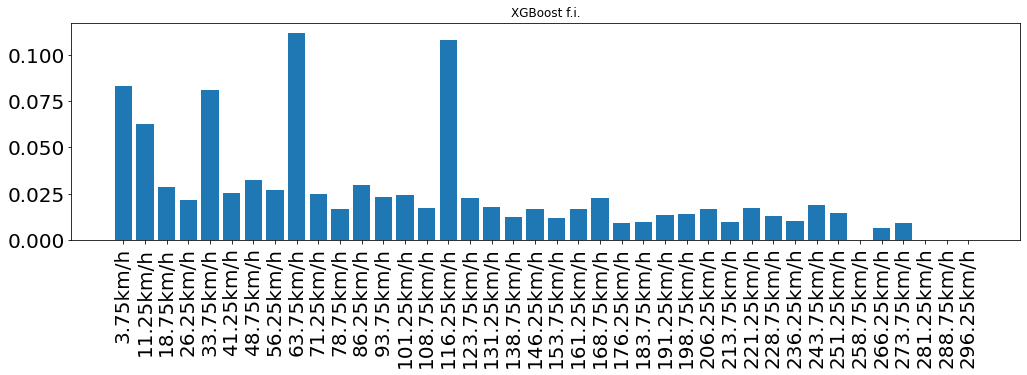

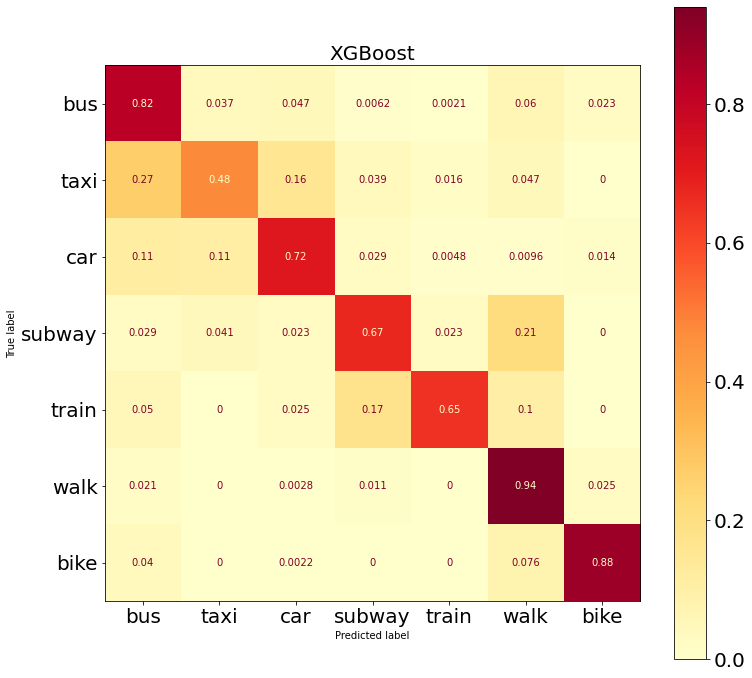

Accuracy from Crossvalidation mean=0.846 std=0.007
precision from Crossvalidation mean=0.787 std=0.020


In [22]:
classificator_analisys(big_df[np.append(big_df.columns[0:40],["label","user"])])

### Using motion + POI + speed distribution feature

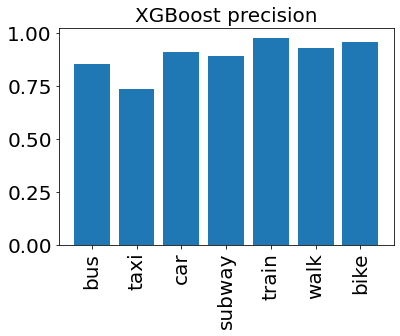

avg precision= 0.895


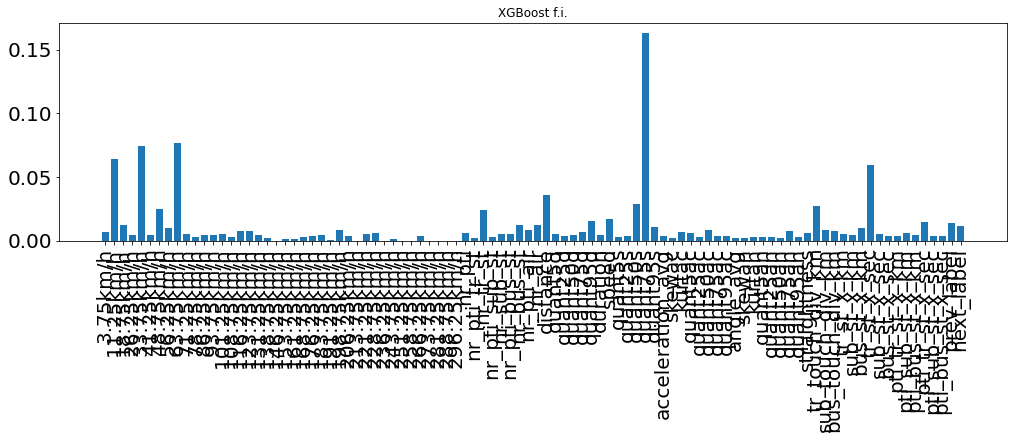

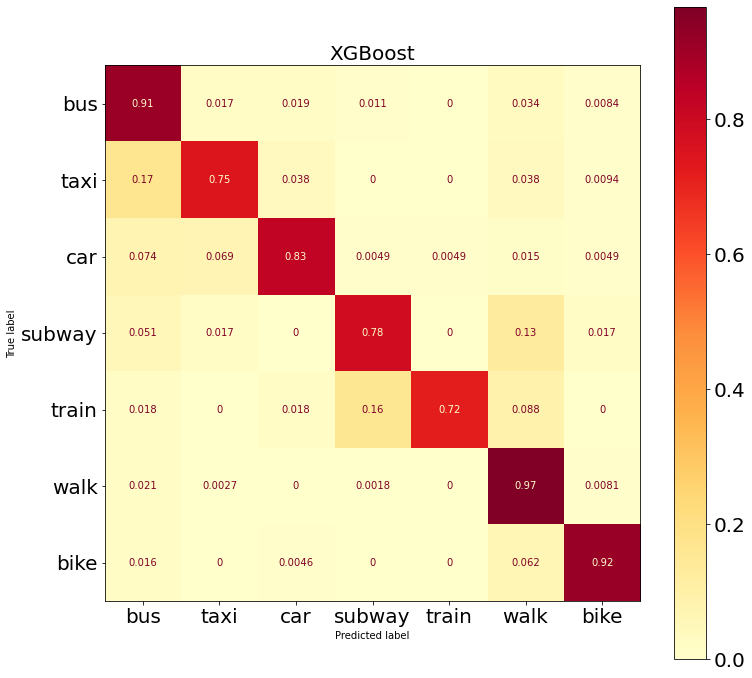

Accuracy from Crossvalidation mean=0.910 std=0.006
precision from Crossvalidation mean=0.884 std=0.017


In [23]:
classificator_analisys(big_df)

# downsampling training set
    Sometimes gps trajectories in real use cases can have an uneven and low sampling rate, i will use the timedelta column from a gps dataset with sparse samples to degradate the chinese training set. So I will assess that lower sampling rates don't degradate too much the predictive performances.

In [28]:
import os
import time
from datetime import datetime

folder_list=os.listdir("Milan_oecd/daily_events_new")
if ".DS_Store" in folder_list: folder_list.remove(".DS_Store")
folder_list=[int(x) for x in folder_list]
folder_list.sort()
folder_list=[str(x) for x in folder_list]
file_names=[]
paths=[]
for i in enumerate(folder_list):
    files_in_userfolder=os.listdir("Milan_oecd/daily_events_new/"+i[1])
    if ".DS_Store" in files_in_userfolder:
        files_in_userfolder.remove(".DS_Store")
    bool_selector=[len(files_in_userfolder[0])==59,len(files_in_userfolder[1])==59,len(files_in_userfolder[2])==59]
    file_names.append(files_in_userfolder[np.where(bool_selector)[0][0]])
    paths.append("Milan_oecd/daily_events_new/"+i[1]+"/"+files_in_userfolder[np.where(bool_selector)[0][0]])

curr_df=pd.read_csv(paths[10])
curr_df=curr_df[-curr_df.trip_labels.str.contains("is_stop")]
curr_df["date"]=curr_df.UTC.apply(lambda x: time.strftime('%Y-%m-%d', time.localtime(x)))
curr_df["day_of_week"]=curr_df.UTC.apply(lambda x: datetime.fromtimestamp(x).weekday())
curr_df=curr_df[(curr_df.day_of_week!=5)&(curr_df.day_of_week!=6)]
#tripID
support_df=pd.DataFrame()
support_df["trip_labels"]=(curr_df["trip_labels"] != curr_df["trip_labels"].shift(1))*1
support_df["userchange"]=(curr_df["UID"] != curr_df["UID"].shift(1))*1
curr_df["tripID"]=np.cumsum(support_df["userchange"] | support_df["trip_labels"])
#remove duplicates
curr_df=curr_df[(-curr_df[["UTC","UID"]].duplicated())&(-curr_df[["lon","lat","UID"]].duplicated())]
#timedelta
curr_df['timedelta'] = curr_df.UTC.shift(-1) - curr_df.UTC
#spacedelta
curr_df["spacedelta"]=haversine_np(curr_df.lon, curr_df.lat, curr_df.lon.shift(-1), curr_df.lat.shift(-1))*1000 #m
#speed
curr_df['speed']=curr_df['spacedelta']/curr_df['timedelta']*3.6
#angle
x,y=utm.from_latlon(np.array(curr_df.lat),np.array(curr_df.lon))[0:2]
curr_df["utm"]=list(zip(x,y))
curr_df["previous_utm"]=curr_df.shift(+1).utm
curr_df["next_utm"]=curr_df.shift(-1).utm
curr_df["angle"] = curr_df.swifter.apply(lambda x: getAngle(x.previous_utm, x.utm, x.next_utm), axis=1)
curr_df.drop(columns=["utm","previous_utm","next_utm"],inplace=True)
#acceleration
curr_df["acceleration"]=(curr_df["speed"].shift(-1)-curr_df["speed"])/3.6/curr_df["timedelta"]
#invalido le feature di inizio/fine fiaggio insensate
curr_df["timedelta"][curr_df.tripID!=curr_df.tripID.shift(-1)]=np.nan
curr_df["spacedelta"][curr_df.tripID!=curr_df.tripID.shift(-1)]=np.nan
curr_df["speed"][curr_df.tripID!=curr_df.tripID.shift(-1)]=np.nan
curr_df["angle"][(curr_df.tripID!=curr_df.tripID.shift(-1))|(curr_df.tripID!=curr_df.tripID.shift(1))]=np.nan
curr_df["acceleration"][(curr_df.tripID!=curr_df.tripID.shift(-1))|(curr_df.tripID!=curr_df.tripID.shift(-2))]=np.nan

Pandas Apply:   0%|          | 0/17167912 [00:00<?, ?it/s]

In [31]:
curr_df[["UTC","tripID","timedelta"]].to_csv("real_use_case_timedeltas.csv")

In [32]:
#columns are: UTC (timestamp in UTC format), tripID (unique identidifier for trips), timedelta (time distance from actual point and next one)
curr_df=pd.read_csv("real_use_case_timedeltas.csv")

In [35]:
#######################################################################  DOWNSAMPLING  ######################################################################
cilindro_magico = curr_df[(0 < curr_df.timedelta)&(curr_df.timedelta < 30*60)]["timedelta"]

indexes=bboxed_labelled_df.groupby("tripID").agg(
    indexes=("timedelta",lambda x: estrattore(x,cilindro_magico))
).explode("indexes")

downsampled_pechino=bboxed_labelled_df.iloc[indexes[-indexes.indexes.isna()].indexes.values]

#timedelta
downsampled_pechino['timedelta'] = (downsampled_pechino.time.shift(-1) - downsampled_pechino.time).apply(lambda x: x.total_seconds())

#spacedelta
downsampled_pechino["spacedelta"]=haversine_np(downsampled_pechino.lon, downsampled_pechino.lat, downsampled_pechino.lon.shift(-1), downsampled_pechino.lat.shift(-1))*1000 #m

#angle
x,y=utm.from_latlon(np.array(downsampled_pechino.lat),np.array(downsampled_pechino.lon))[0:2]
downsampled_pechino["utm"]=list(zip(x,y))
downsampled_pechino["previous_utm"]=downsampled_pechino.shift(+1).utm
downsampled_pechino["next_utm"]=downsampled_pechino.shift(-1).utm
downsampled_pechino["angle"] = downsampled_pechino.swifter.apply(lambda x: getAngle(x.previous_utm, x.utm, x.next_utm), axis=1)
downsampled_pechino.drop(columns=["utm","previous_utm","next_utm"],inplace=True)

#speed
downsampled_pechino['speed']=downsampled_pechino['spacedelta']/downsampled_pechino['timedelta']*3.6

#acceleration
downsampled_pechino["acceleration"]=(downsampled_pechino["speed"].shift(-1)-downsampled_pechino["speed"])/3.6/downsampled_pechino["timedelta"]

#invalido le feature di inizio/fine fiaggio insensate
downsampled_pechino["timedelta"][downsampled_pechino.tripID!=downsampled_pechino.tripID.shift(-1)]=np.nan
downsampled_pechino["spacedelta"][downsampled_pechino.tripID!=downsampled_pechino.tripID.shift(-1)]=np.nan
downsampled_pechino["speed"][downsampled_pechino.tripID!=downsampled_pechino.tripID.shift(-1)]=np.nan
downsampled_pechino["angle"][(downsampled_pechino.tripID!=downsampled_pechino.tripID.shift(-1))|(downsampled_pechino.tripID!=downsampled_pechino.tripID.shift(1))]=np.nan
downsampled_pechino["acceleration"][(downsampled_pechino.tripID!=downsampled_pechino.tripID.shift(-1))|(downsampled_pechino.tripID!=downsampled_pechino.tripID.shift(-2))]=np.nan

Pandas Apply:   0%|          | 0/53456 [00:00<?, ?it/s]

In [36]:
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'

# READ KML file to a geopandas dataframe 

geo_train_stations = gpd.read_file('train_stations2.kml',driver='KML')
geo_subway_stations = gpd.read_file('subway_stations.kml',driver='KML')
geo_bus_stops = gpd.read_file('bus_stops.kml',driver='KML')
geo_airports = gpd.read_file('airports.kml',driver='KML')
geo_airports['geometry'] = geo_airports.centroid
# Create Pandas Dataframe from GeoPandas 

train_stations= pd.DataFrame(geo_train_stations)
subway_stations= pd.DataFrame(geo_subway_stations)
bus_stops= pd.DataFrame(geo_bus_stops)
airports= pd.DataFrame(geo_airports)


# Extract latitude and longitude from the KML geometry column
train_stations['lat'] = train_stations.geometry.apply(lambda p: p.y)
train_stations['lon'] = train_stations.geometry.apply(lambda p: p.x)
subway_stations['lat'] = subway_stations.geometry.apply(lambda p: p.y)
subway_stations['lon'] = subway_stations.geometry.apply(lambda p: p.x)
bus_stops['lat'] = bus_stops.geometry.apply(lambda p: p.y)
bus_stops['lon'] = bus_stops.geometry.apply(lambda p: p.x)
airports['lat'] = airports.geometry.apply(lambda p: p.y)
airports['lon'] = airports.geometry.apply(lambda p: p.x)

#per ogni punto valuto: appartiene alla stazione? quale stazione?

downsampled_pechino["train_station"]=False
downsampled_pechino["tr_st_id"]=""
for i in train_stations.index:
    belong_to_curr_station= (haversine_np(train_stations.loc[i,"lon"], train_stations.loc[i,"lat"], downsampled_pechino["lon"], downsampled_pechino["lat"])<0.3)
    downsampled_pechino["train_station"]= (downsampled_pechino["train_station"]) | (belong_to_curr_station) #distanza tra la stazione e ciascun punto < 0,3km
    downsampled_pechino["tr_st_id"].loc[belong_to_curr_station]=i #dove è presente una stazione, gli assegno i come ID
    
downsampled_pechino["subway_station"]=False
downsampled_pechino["sub_st_id"]=""
for i in subway_stations.index:
    belong_to_curr_station= (haversine_np(subway_stations.loc[i,"lon"], subway_stations.loc[i,"lat"], downsampled_pechino["lon"], downsampled_pechino["lat"])<0.1)
    downsampled_pechino["subway_station"]= (downsampled_pechino["subway_station"]) | (belong_to_curr_station) #distanza tra la stazione e ciascun punto < 0,3km
    downsampled_pechino["sub_st_id"].loc[belong_to_curr_station]=i #dove è presente una stazione, gli assegno i come ID

downsampled_pechino["bus_stop"]=False
downsampled_pechino["bus_st_id"]=""
for i in bus_stops.index:
    belong_to_curr_station= (haversine_np(bus_stops.loc[i,"lon"], bus_stops.loc[i,"lat"], downsampled_pechino["lon"], downsampled_pechino["lat"])<0.1)
    downsampled_pechino["bus_stop"]= (downsampled_pechino["bus_stop"]) | (belong_to_curr_station) #distanza tra la stazione e ciascun punto < 0,3km
    downsampled_pechino["bus_st_id"].loc[belong_to_curr_station]=i #dove è presente una stazione, gli assegno i come ID
    
downsampled_pechino["airport"]=False
downsampled_pechino["airport_id"]=""
for i in airports.index:
    belong_to_curr_station= (haversine_np(airports.loc[i,"lon"], airports.loc[i,"lat"], downsampled_pechino["lon"], downsampled_pechino["lat"])<0.5)
    downsampled_pechino["airport"]= (downsampled_pechino["airport"]) | (belong_to_curr_station) #distanza tra la stazione e ciascun punto < 0,5km
    downsampled_pechino["airport_id"].loc[belong_to_curr_station]=i #dove è presente una stazione, gli assegno i come ID

In [37]:
clas_df=downsampled_pechino.groupby('tripID').agg(
    
    user=("user", "first"),
    label=("label", "first"),
    
    lon_start=("lon", "first"),
    lat_start=("lat", "first"),
    lon_end=("lon", "last"),
    lat_end=("lat", "last"),
    
    nr_pti=("user", len),
    nr_pti_tr_st=("train_station", sum), #numero punti in stazioni treno
    nr_tr_st=("tr_st_id", lambda x: len(x.unique())-1), #numero stazioni uniche toccate
    nr_pti_sub_st=("subway_station", sum), #numero punti in stazioni metro
    nr_sub_st=("sub_st_id", lambda x: len(x.unique())-1), #numero stazioni uniche toccate
    nr_pti_bus_st=("bus_stop", sum), #numero punti in bus stop
    nr_bus_st=("bus_st_id", lambda x: len(x.unique())-1), #numero stazioni uniche toccate
    nr_pti_air=("airport", sum), #numero punti in bus stop
    nr_air=("airport_id", lambda x: len(x.unique())-1), #numero stazioni uniche toccate
    
    distance=('spacedelta', sum), #beeline distance, point to point
    quant5d=("spacedelta", lambda x: x.quantile(0.05)),
    quant25d=("spacedelta", lambda x: x.quantile(0.25)),
    quant50d=("spacedelta", lambda x: x.quantile(0.5)),
    quant75d=("spacedelta", lambda x: x.quantile(0.75)),
    quant95d=("spacedelta", lambda x: x.quantile(0.95)),
    
    duration=('timedelta', sum),
    
    speed=("speed", "mean"),
    quant5s=("speed", lambda x: x.quantile(0.05)),
    quant25s=("speed", lambda x: x.quantile(0.25)),
    quant50s=("speed", lambda x: x.quantile(0.5)),
    quant75s=("speed", lambda x: x.quantile(0.75)),
    quant95s=("speed", lambda x: x.quantile(0.95)),
    
    #acceleration
    acceleration_avg=("acceleration", "mean"),
    skewac=("acceleration", "skew"),
    kurtac=("acceleration", lambda x: x.kurt()),
    quant5ac=("acceleration", lambda x: x.quantile(0.05)),
    quant25ac=("acceleration", lambda x: x.quantile(0.25)),
    quant50ac=("acceleration", lambda x: x.quantile(0.5)),
    quant75ac=("acceleration", lambda x: x.quantile(0.75)),
    quant95ac=("acceleration", lambda x: x.quantile(0.95)),
    
    angle_avg=("angle", "mean"),
    skewan=("angle", "skew"),
    kurtan=("angle", lambda x: x.kurt()),
    quant5an=("angle", lambda x: x.quantile(0.05)),
    quant25an=("angle", lambda x: x.quantile(0.25)),
    quant50an=("angle", lambda x: x.quantile(0.5)),
    quant75an=("angle", lambda x: x.quantile(0.75)),
    quant95an=("angle", lambda x: x.quantile(0.95))
    
)

clas_df["straightness"]=haversine_np(clas_df["lon_start"], clas_df["lat_start"], clas_df["lon_end"], clas_df["lat_end"])/clas_df["distance"]
clas_df.drop(columns=['lon_start','lon_end','lat_start','lat_end'], inplace=True)

# POI features
clas_df["tr_touch_div_km"]=(clas_df["nr_tr_st"]>0)/clas_df["distance"] #stazione si/no / km , feature strana ma funziona
clas_df["sub_touch_div_km"]=(clas_df["nr_sub_st"]>0)/clas_df["distance"]
clas_df["bus_touch_div_km"]=(clas_df["nr_bus_st"]>0)/clas_df["distance"]

clas_df["tr_st_x_km"]=clas_df["nr_tr_st"]/clas_df["distance"]
clas_df["sub_st_x_km"]=clas_df["nr_sub_st"]/clas_df["distance"]
clas_df["bus_st_x_km"]=clas_df["nr_bus_st"]/clas_df["distance"]

clas_df["tr_st_x_sec"]=clas_df["nr_tr_st"]/clas_df["duration"]
clas_df["sub_st_x_sec"]=clas_df["nr_sub_st"]/clas_df["duration"]
clas_df["bus_st_x_sec"]=clas_df["nr_bus_st"]/clas_df["duration"]

clas_df["pti_tr_st_x_km"]=clas_df["nr_pti_tr_st"]/clas_df["distance"]
clas_df["pti_sub_st_x_km"]=clas_df["nr_pti_sub_st"]/clas_df["distance"]
clas_df["pti_bus_st_x_km"]=clas_df["nr_pti_bus_st"]/clas_df["distance"]

clas_df["pti_tr_st_x_sec"]=clas_df["nr_pti_tr_st"]/clas_df["duration"]
clas_df["pti_sub_st_x_sec"]=clas_df["nr_pti_sub_st"]/clas_df["duration"]
clas_df["pti_bus_st_x_sec"]=clas_df["nr_pti_bus_st"]/clas_df["duration"]

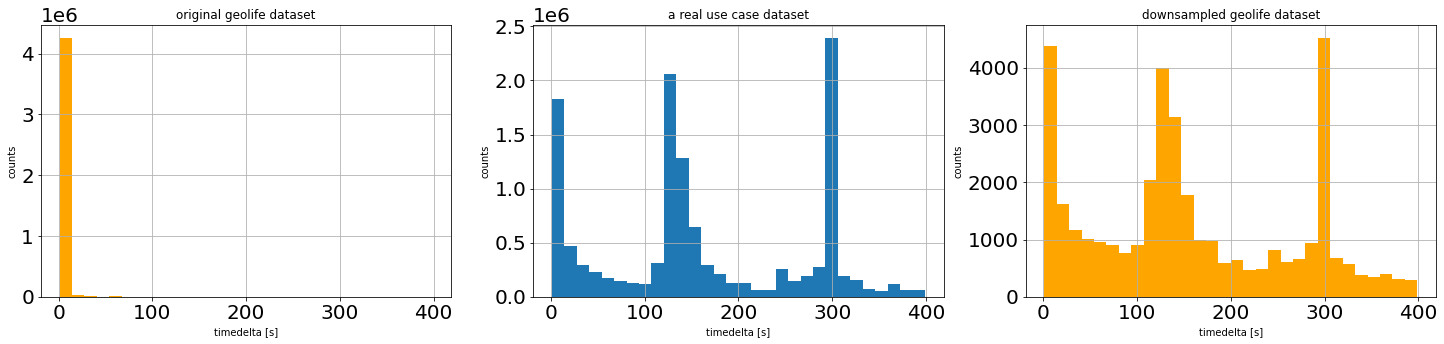

In [58]:
plt.figure(figsize=(25,5))

plt.subplot(1,3,1)
bboxed_labelled_df.timedelta[(bboxed_labelled_df.timedelta>0)&(bboxed_labelled_df.timedelta<400)].hist(bins=30, color="orange")
plt.xlabel("timedelta [s]")
plt.ylabel("counts")
plt.title("original geolife dataset")

plt.subplot(1,3,2)
curr_df.timedelta[curr_df.timedelta<400].hist(bins=30)
plt.xlabel("timedelta [s]")
plt.ylabel("counts")
plt.title("a real use case dataset")

plt.subplot(1,3,3)
downsampled_pechino.timedelta[downsampled_pechino.timedelta<400].hist(bins=30, color="orange")
plt.xlabel("timedelta [s]")
plt.ylabel("counts")
plt.title("downsampled geolife dataset")

plt.show()

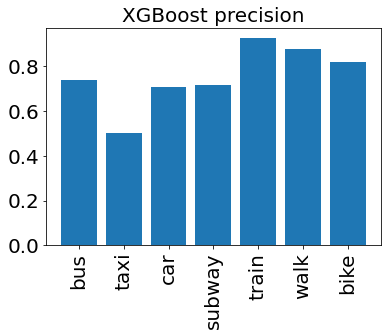

avg precision= 0.755


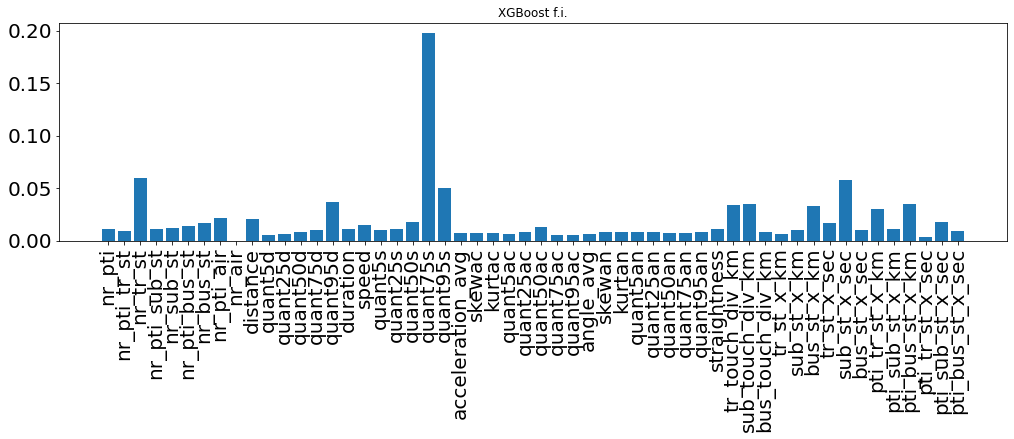

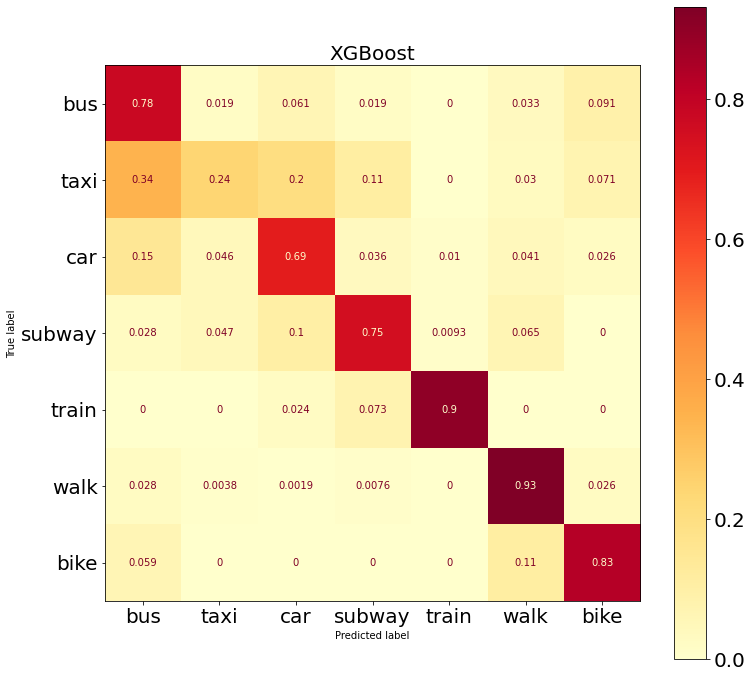

Accuracy from Crossvalidation mean=0.788 std=0.014
precision from Crossvalidation mean=0.665 std=0.067


In [65]:
#evaluating performances on downsampled ground truth
classificator_analisys(clas_df[clas_df.nr_pti>2])